# Introduction 
* This code is adapted from the example provided in the python optimal transport package 

This notebook presents the results of mapping a 2D uniform input distribution to a 3D uniform target distribution on the unit cube.


## Imports

In [1]:
%matplotlib inline
%matplotlib widget
# import sys
# !{sys.executable} -m pip install pot
# !{sys.executable} -m pip install ipympl 
# !{sys.executable} -m pip install ipywidgets

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch import nn
import ot
import scipy

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

seed = 126
torch.manual_seed(seed) # make chunk execution consistent 

__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 4080
__CUDA Device Total Memory [GB]: 16.860184576


## Data generation

In [2]:
torch.manual_seed(seed) # make chunk execution consistent 
sigma = 0.0
n_dims = 3
n_features = 2


def get_data(n_samples):
    # c = torch.rand(size=(n_samples, 2))
    c1 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c2 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c3 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)

    c = torch.cartesian_prod(c1,c2, c3)
    x = c
    return x

def get_data_2d(n_samples):
    # c = torch.rand(size=(n_samples, 2))
    c1 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c2 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c = torch.cartesian_prod(c1,c2)
    x = c
    return x

# empirical fill-based loss  
from scipy.spatial.distance import cdist
def fill_distance(data, fitted, type='max'): 
    m = torch.tensor(cdist(data, fitted, 'euclidean')) 
    # m = cdist(data, fitted, 'euclidean')
    min, min_indices = torch.min(m, dim=1) # min across rows 
    if type=='max':
        fill_dist = max(min)
    elif type=='mean':
        fill_dist = torch.mean(min)
    else:
        fill_dist = max(min)

    return fill_dist.item() # get actual float 

## Plot data



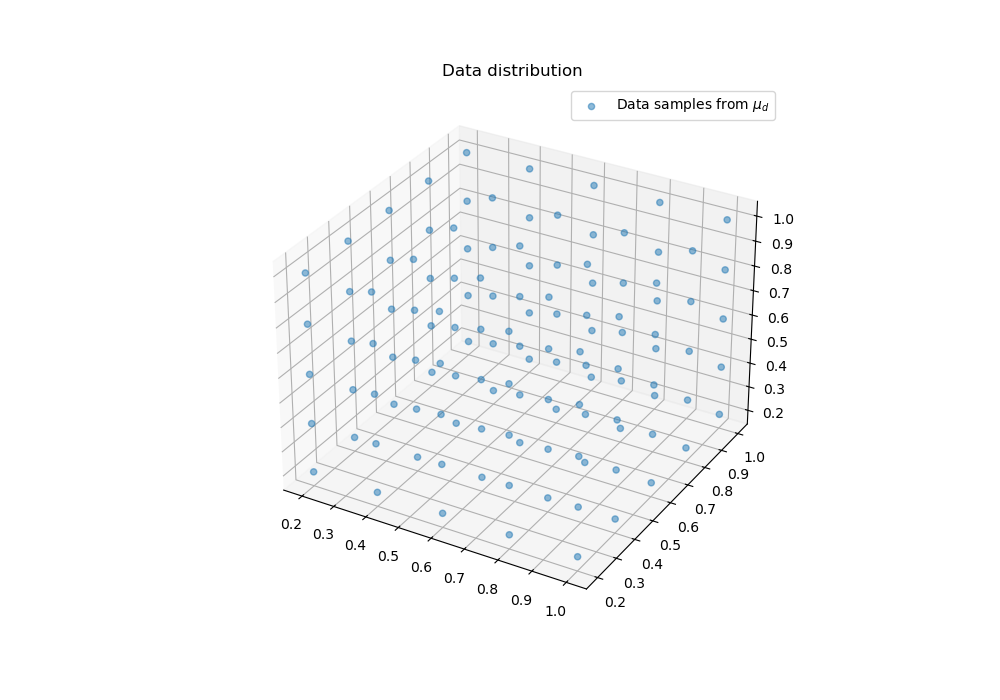

In [3]:
torch.manual_seed(seed) # make chunk execution consistent 
from mpl_toolkits import mplot3d

# plot the distributions
x = get_data(5)
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# creating plot
plt.title("simple 3D scatter plot")
ax.scatter3D(x[:, 0], x[:, 1], x[:, 2], label='Data samples from $\mu_d$', alpha=0.5)
plt.title('Data distribution')
plt.legend()



## Generator Model



In [4]:
torch.manual_seed(seed) # make chunk execution consistent 
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 2
        self.n_out = 3
        leaky = 0.0001
        w_layer = 256
        self.model = nn.Sequential( 
            nn.Linear(self.n_features, w_layer),
            nn.LeakyReLU(leaky),
        )
        for i in range(0,3): # 2
            temp = nn.Sequential(
                nn.Linear(w_layer, w_layer),
                nn.LeakyReLU(leaky),
            )
            self.model.append(temp)
            
        self.model.append(nn.Linear(w_layer, self.n_out))
        
    def forward(self, x):
        x = self.model(x)
        return x
    
g = Generator()
num_hidden_layers = sum(1 for _ in g.modules() if isinstance(_, nn.Linear))
print(f"The number of hidden layers is: {num_hidden_layers}")

The number of hidden layers is: 5


## Training the model



Iter: 0, 	 wass-loss=1.20444, 	 fill-dist=1.05616
Iter: 10, 	 wass-loss=0.20067, 	 fill-dist=0.38612
Iter: 20, 	 wass-loss=0.1558, 	 fill-dist=0.32643
Iter: 30, 	 wass-loss=0.10938, 	 fill-dist=0.25051
Iter: 40, 	 wass-loss=0.09904, 	 fill-dist=0.23874
Iter: 50, 	 wass-loss=0.09775, 	 fill-dist=0.24612
Iter: 60, 	 wass-loss=0.08984, 	 fill-dist=0.24317
Iter: 70, 	 wass-loss=0.08689, 	 fill-dist=0.24051
Iter: 80, 	 wass-loss=0.08767, 	 fill-dist=0.24224
Iter: 90, 	 wass-loss=0.08391, 	 fill-dist=0.24055
Iter: 100, 	 wass-loss=0.08424, 	 fill-dist=0.2358
Iter: 110, 	 wass-loss=0.08151, 	 fill-dist=0.23119
Iter: 120, 	 wass-loss=0.07746, 	 fill-dist=0.2255
Iter: 130, 	 wass-loss=0.07071, 	 fill-dist=0.21455
Iter: 140, 	 wass-loss=0.0613, 	 fill-dist=0.19954
Iter: 150, 	 wass-loss=0.05179, 	 fill-dist=0.18248
Iter: 160, 	 wass-loss=0.04357, 	 fill-dist=0.1657
Iter: 170, 	 wass-loss=0.03913, 	 fill-dist=0.15545
Iter: 180, 	 wass-loss=0.0364, 	 fill-dist=0.14345
Iter: 190, 	 wass-loss=0.0333

Text(0.5, 0, 'Iterations')

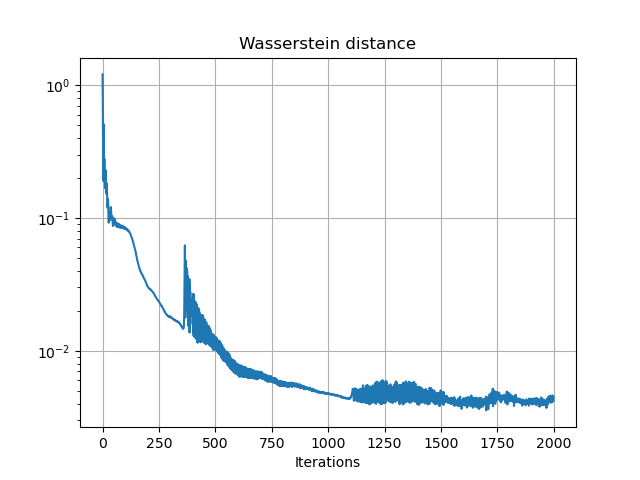

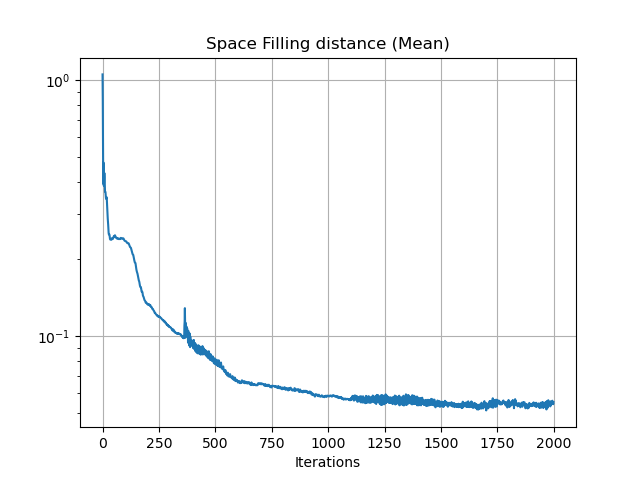

In [5]:
torch.manual_seed(seed) # make chunk execution consistent 
G = Generator()
optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5)
# optimizer = torch.optim.Adam(G.parameters(), lr=0.005, eps=1e-5)

# number of iteration and size of the batches
n_iter = 2000 
size_batch = 9

# generate static samples to see their trajectory along training
n_visu = 2000
xnvisu = torch.rand(n_visu, n_features)
xvisu = torch.zeros(n_iter, n_visu, n_dims)

ab = torch.ones(size_batch**3) / size_batch**3
losses = []
fill_losses = []

for i in range(n_iter):

    # generate noise samples
    # xn = torch.rand(size_batch**3, n_features) # just gives size_batch correctly
    xn = get_data_2d(27)

    # generate data samples
    xd = get_data(size_batch)

    # generate sample along iterations
    xvisu[i, :, :] = G(xnvisu).detach()

    # generate samples and compute distance matrix
    xg = G(xn)
    M = ot.dist(xg, xd)
    loss = ot.emd2(ab, ab, M)
    losses.append(float(loss.detach()))
  
    fill_loss = fill_distance(xd.detach().numpy(), xg.detach().numpy(), type='mean')
    fill_losses.append(fill_loss)

    if i % 10 == 0:
        # print("Iter: {:3d}, loss={}".format(i, losses[-1]))
        print(f"Iter: {i}, \t wass-loss={round(losses[-1], 5)}, \t fill-dist={round(fill_loss, 5)}")

    loss.backward()
    optimizer.step()

    del M

# wasserstein loss 
plt.figure(2)
plt.semilogy(losses)
plt.grid()
plt.title('Wasserstein distance')
plt.xlabel("Iterations")

# fill distance 
plt.figure(3)
plt.semilogy(fill_losses)
plt.grid()
plt.title('Space Filling distance (Mean)')
plt.xlabel("Iterations")

## Plot trajectories of generated samples along iterations



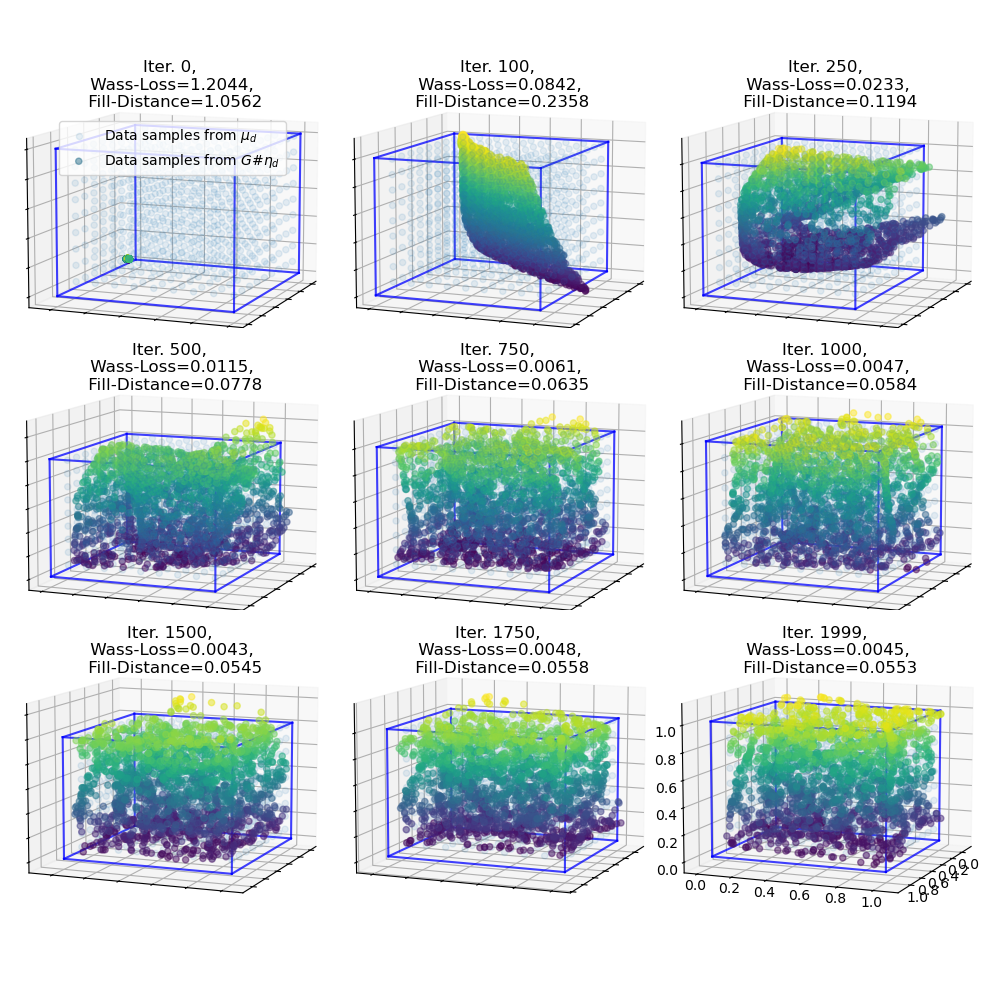

In [6]:
torch.manual_seed(seed) # make chunk execution consistent 
plt.clf()
plt.close('all')
ivisu = [0, 100, 250, 500, 1000, 2000, 3000, 3500, n_iter-1]  
ivisu = [0, 100, 250, 500, 750, 1000, 1500, 1750, n_iter-1]

# create a figure and a 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10), subplot_kw={'projection': '3d'}, edgecolor='none')
# fig.tight_layout(pad=1.0)

# iterate over each subplot to convert it into 3D and plot
for i, ax in enumerate(axs.flat):

    # convert subplot to 3D ---> no need, alr defined above 
        # ax = fig.add_subplot(3, 3, i+1, projection= '3d')

    # adjust the spacing between plots
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-.05, hspace=-.35)
    
    # calculate the distance of each point from the origin (0, 0)
    distances = xvisu[ivisu[i], :, 2]

    # use the distances to map to colors
    colors = distances

    ax.scatter3D(xd[:, 0], xd[:, 1], xd[:, 2], label='Data samples from $\mu_d$', alpha=0.1)
    ax.scatter3D(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], xvisu[ivisu[i], :, 2],
                 label='Data samples from $G\#\eta_d$', 
                 alpha=0.5,
                 c = distances,
                 cmap='viridis'
                 )

    # define the vertices of the unit cube
    vertices = [(0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0),
                (0, 0, 1), (1, 0, 1), (1, 1, 1), (0, 1, 1)]

    # define the edges connecting the vertices
    edges = [(0, 1), (1, 2), (2, 3), (3, 0),
            (4, 5), (5, 6), (6, 7), (7, 4),
            (0, 4), (1, 5), (2, 6), (3, 7)]

    # plot each edge
    for edge in edges:
        # extract the points for this edge
        start, end = edge
        points = [vertices[start], vertices[end]]
        # convert points to format suitable for plotting
        x, y, z = zip(*points)
        # plot the edge
        ax.plot(x, y, z, color='b', alpha = .75)
    
    # set the view 
    # ax.view_init(5, 14, 0) # 5, 22, 0
    ax.view_init(10, 22, 0) 

    # set titles and labels, see issue https://github.com/matplotlib/matplotlib/issues/16805/
    ax.set_title(f'Iter. {ivisu[i]}, \n Wass-Loss={round(losses[ivisu[i]], 4)}, \n Fill-Distance={round(fill_losses[ivisu[i]], 4)}', pad=-25, y=1.000001) # need the 1.00001 to turn off auto 
        #ax.set_xlabel('X axis')
        #ax.set_ylabel('Y axis')
        #ax.set_zlabel('Z axis')
    if i == 0:
        ax.legend(bbox_to_anchor=(.5, .7), loc='center', borderaxespad=0) # bbox in coordinates 
    
     # hide the axis ticks
    if (i != 8): # only keep labels on third figure of each row 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if (i == 8): # readjust x axis to be closer 
        ax.xaxis.set_tick_params(pad=-4)
        ax.yaxis.set_tick_params(pad=-5)
        ax.zaxis.set_tick_params(pad=-1)

    # adjust the visibility of the axes spines
        #ax.spines['top'].set_visible(False)
        #ax.spines['right'].set_visible(False)

plt.show()

